# LineExtraction Python Bindings — Interactive Guide

This notebook demonstrates the five Python binding modules of the LineExtraction
library. Each module wraps high-performance C++ code with zero-copy NumPy
integration via pybind11.

**Modules:**

| Module | Purpose |
|--------|---------|
| `le_imgproc` | Gradient filters, core types (Range, Value, FilterData) |
| `le_edge` | Edge detection, NMS, edge segment extraction |
| `le_geometry` | Line, LineSegment, Polygon, drawing, LineOptimizer |
| `le_eval` | Performance benchmarking framework |
| `le_lsd` | 9 line segment detection algorithms |

**Dependency graph:**

```
le_imgproc       le_geometry       le_eval
(filters)        (primitives)      (benchmarks)
    │                 │
    ▼                 │
 le_edge              │
(NMS, ESD)            │
    │                 │
    ▼                 ▼
         le_lsd
    (9 LSD detectors)
```

> **Prerequisites:** Build all modules with `bazel build //libs/...` before
> running this notebook.

## 1. Import and Setup

Import all five binding modules and verify they loaded correctly.
Show available classes and functions in each module.

In [1]:
import sys, pathlib

# --- Locate workspace root and add Bazel output dirs to sys.path ---
workspace = pathlib.Path.cwd()
# Walk up until we find MODULE.bazel (the workspace root marker)
while not (workspace / "MODULE.bazel").exists():
    if workspace == workspace.parent:
        raise RuntimeError("Cannot find LineExtraction workspace root (MODULE.bazel)")
    workspace = workspace.parent

# Add each binding's Bazel output directory
for lib in ["imgproc", "edge", "geometry", "eval", "lsd"]:
    p = workspace / f"bazel-bin/libs/{lib}/python"
    if p.exists():
        sys.path.insert(0, str(p))
    else:
        print(f"⚠ Not found: {p}  — run: bazel build //libs/{lib}/...")

print(f"Workspace: {workspace}")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit

# NOTE: We do NOT import cv2. The LE bindings ship their own OpenCV build
# (linked statically via Bazel). Using pip's cv2 would cause symbol conflicts.
# All drawing is done via le_geometry functions; color conversion via numpy.

# Import all LineExtraction binding modules
import le_imgproc
import le_edge
import le_geometry
import le_eval
import le_lsd

# Quick summary of each module
for name, mod in [
    ("le_imgproc", le_imgproc),
    ("le_edge", le_edge),
    ("le_geometry", le_geometry),
    ("le_eval", le_eval),
    ("le_lsd", le_lsd),
]:
    public = [x for x in dir(mod) if not x.startswith("_")]
    print(f"{name:14s}  {len(public):3d} symbols  ({', '.join(public[:6])}, ...)")

print("\nAll modules loaded successfully.")

Workspace: /home/waterben/workspace/LineExtraction
le_imgproc       37 symbols  (FilterData, FilterI, FilterI_16u, FilterI_f32, FilterI_f64, GradientBase, ...)
le_edge          43 symbols  (ESDirectionOptions, ESQuadratureOptions, ES_CLOSED, ES_NONE, ES_REVERSE, EdgeSegment, ...)
le_geometry      29 symbols  (Line, LineSegment, LineSegment_f64, Line_f64, Polygon, Polygon_f64, ...)
le_eval          20 symbols  (CVData, CVPerformanceData, CVPerformanceMeasure, CVPerformanceTask, CVPerformanceTest, FileCVDataProvider, ...)
le_lsd           36 symbols  (BURNS_NMS, CC_ADD_THICK_PIXELS, CC_CORNER_RULE, CC_FIND_NEAR_COMPLEX, DataDescriptorEntry, EL_USE_NFA, ...)

All modules loaded successfully.


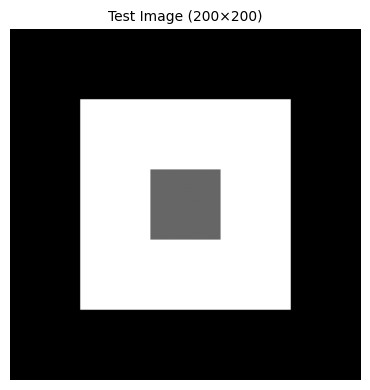

In [2]:
# Helper: create a synthetic test image with clear edges
def make_test_image(size: int = 200) -> np.ndarray:
    """Create a uint8 grayscale image with a bright rectangle and inner square."""
    img = np.zeros((size, size), dtype=np.uint8)
    s = size
    img[s // 5 : 4 * s // 5, s // 5 : 4 * s // 5] = 200   # outer rectangle
    img[2 * s // 5 : 3 * s // 5, 2 * s // 5 : 3 * s // 5] = 80  # inner square
    return img

# Helper: display images in a row
def show_images(images: list, titles: list, cmap: str = "gray", figsize=None):
    """Show a list of images side by side."""
    n = len(images)
    if figsize is None:
        figsize = (4 * n, 4)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap=cmap if img.ndim == 2 else None)
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

test_img = make_test_image()
show_images([test_img], ["Test Image (200×200)"])

## 2. Basic Binding Calls — le_imgproc

Compute gradients using the C++ Sobel, Scharr, and Prewitt operators.
These calls execute optimised C++ code and return NumPy arrays directly
(zero-copy where possible).

Magnitude:  dtype=float32, shape=(200, 200), range=[0.0, 848.5281372070312]
Direction:  dtype=float32, shape=(200, 200)
Gx:         dtype=int16, Gy: dtype=int16


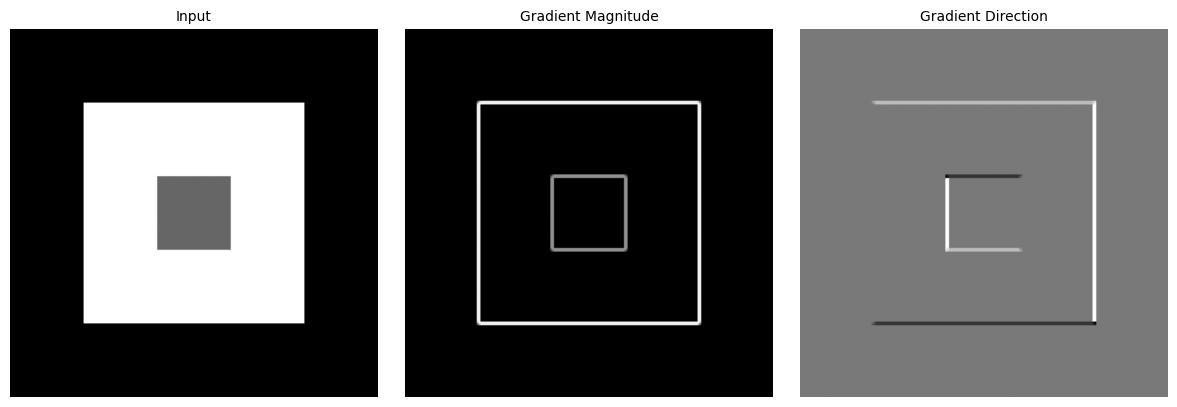

In [3]:
# Compute Sobel gradient
grad = le_imgproc.SobelGradient()
grad.process(test_img)

mag = grad.magnitude()
direction = grad.direction()
gx, gy = grad.gx(), grad.gy()

print(f"Magnitude:  dtype={mag.dtype}, shape={mag.shape}, range=[{mag.min()}, {mag.max()}]")
print(f"Direction:  dtype={direction.dtype}, shape={direction.shape}")
print(f"Gx:         dtype={gx.dtype}, Gy: dtype={gy.dtype}")

show_images(
    [test_img, mag, direction],
    ["Input", "Gradient Magnitude", "Gradient Direction"],
)

Sobel     max=849  name='derivative_sobel'
Scharr    max=3677  name='derivative_scharr'
Prewitt   max=600  name='derivative_prewitt'


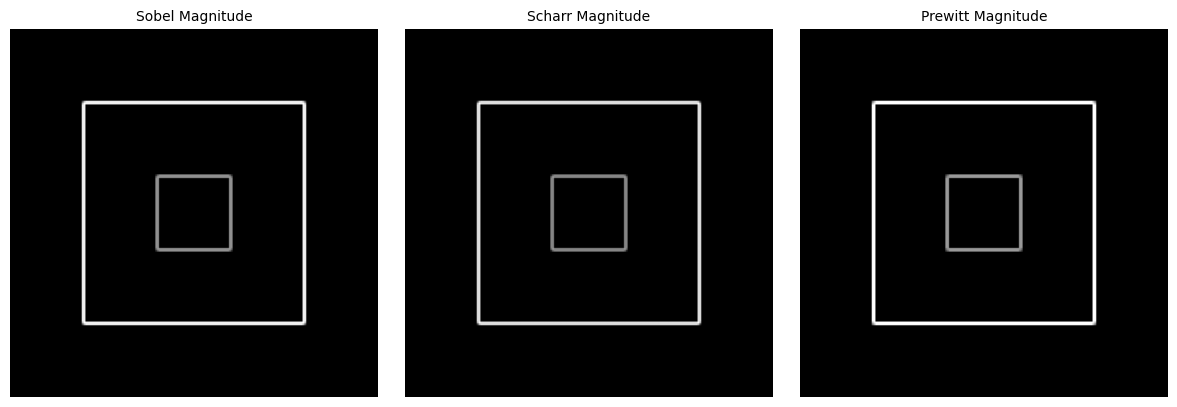

In [4]:
# Compare all three gradient operators
operators = {
    "Sobel": le_imgproc.SobelGradient(),
    "Scharr": le_imgproc.ScharrGradient(),
    "Prewitt": le_imgproc.PrewittGradient(),
}

mags = []
titles = []
for name, grad_op in operators.items():
    grad_op.process(test_img)
    m = grad_op.magnitude().astype(np.float32)
    mags.append(m)
    titles.append(f"{name} Magnitude")
    print(f"{name:8s}  max={m.max():.0f}  name='{grad_op.name()}'")

show_images(mags, titles)

## 3. Data Type Mapping — Python ↔ C++

The bindings provide transparent mapping between Python/NumPy types and
C++ types. This section demonstrates how `Range`, `Value`, `FilterData`,
and `ValueManager` work as Python objects wrapping C++ data.

In [5]:
# Range types — typed numeric intervals (int, float, double, etc.)
ri = le_imgproc.RangeI(0, 255)
rf = le_imgproc.RangeF(-1.0, 1.0)
rd = le_imgproc.RangeD(0.0, 6.283)
print(f"RangeI: [{ri.lower}, {ri.upper}], size={ri.size()}")
print(f"RangeF: [{rf.lower}, {rf.upper}], size={rf.size():.2f}")

# Value — variant type (int, float, bool, string)
v_int = le_imgproc.Value(42)
v_flt = le_imgproc.Value(3.14)
v_bool = le_imgproc.Value(True)
v_str = le_imgproc.Value("hello")
print(f"\nValue(42):     get_int()={v_int.get_int()}")
print(f"Value(3.14):   get_float()={v_flt.get_float():.2f}")
print(f"Value(True):   get_bool()={v_bool.get_bool()}")
print(f"Value('hello'): get_string()='{v_str.get_string()}'")

# FilterData — wraps a cv::Mat (numpy) + range metadata
data = np.random.rand(50, 50).astype(np.float64)
fd = le_imgproc.FilterData(data, 0.0, 1.0)
print(f"\nFilterData: shape={fd.data.shape}, dtype={fd.data.dtype}")
print(f"  range: [{fd.range.lower:.1f}, {fd.range.upper:.1f}]")

# Round-trip: numpy → FilterData → numpy
assert np.allclose(fd.data, data), "Round-trip failed!"
print("  Round-trip consistency: ✓")

RangeI: [0, 255], size=255
RangeF: [-1.0, 1.0], size=2.00

Value(42):     get_int()=42
Value(3.14):   get_float()=3.14
Value(True):   get_bool()=True
Value('hello'): get_string()='hello'

FilterData: shape=(50, 50), dtype=float64
  range: [0.0, 1.0]
  Round-trip consistency: ✓


## 4. Complex Data Structures — Geometry Primitives

Create Lines, LineSegments, and Polygons. These are full C++ objects with
rich APIs exposed to Python: transformations, intersections, drawing, and
coordinate conversions.

Line: normal=(0.0, 1.0), dist=50.0
  angle=-0.0000 rad, valid=True
  distance from (100, 60) = 10.0

Segment 1: LineSegment((10, 50) -> (190, 50), len=180)
  length=180.0, center=(100.0, 50.0)
Segment 2: LineSegment((100, 10) -> (100, 190), len=180)
  length=180.0

Intersection of y=50 and x=100: (100.0, 50.0)
Rotated: LineSegment((9.55336, 52.9552) -> (181.514, 106.149), len=180)


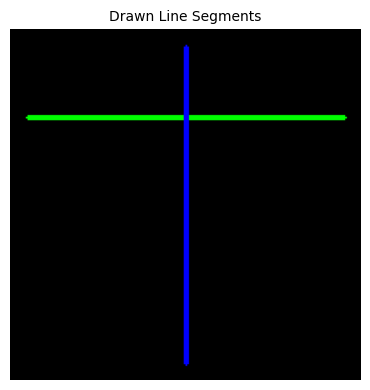

In [6]:
# Line — infinite 2D line in Hesse normal form (n·p = d)
line = le_geometry.Line(0.0, 1.0, 50.0)  # horizontal line at y=50
print(f"Line: normal=({line.normal_x}, {line.normal_y}), dist={line.origin_dist}")
print(f"  angle={line.angle:.4f} rad, valid={line.valid()}")
print(f"  distance from (100, 60) = {line.distance(100.0, 60.0):.1f}")

# LineSegment — finite segment from endpoints
seg1 = le_geometry.LineSegment.from_endpoints(10.0, 50.0, 190.0, 50.0)
seg2 = le_geometry.LineSegment.from_endpoints(100.0, 10.0, 100.0, 190.0)
print(f"\nSegment 1: {seg1}")
print(f"  length={seg1.length:.1f}, center={seg1.center_point()}")
print(f"Segment 2: {seg2}")
print(f"  length={seg2.length:.1f}")

# Line intersection
pt = line.intersection(le_geometry.Line(1.0, 0.0, 100.0))
print(f"\nIntersection of y=50 and x=100: {pt}")

# Transformations
rotated = seg1.rotated(0.3, 0.0)  # rotate 0.3 rad around midpoint
print(f"Rotated: {rotated}")

# Draw segments on an image
canvas = np.zeros((200, 200, 3), dtype=np.uint8)
seg1.draw(canvas, color=[0, 255, 0], thickness=2)
seg2.draw(canvas, color=[0, 0, 255], thickness=2)
show_images([canvas], ["Drawn Line Segments"])

Polygon: 4 vertices, convex=True
  vertices: [(30.0, 30.0), (170.0, 50.0), (150.0, 170.0), (50.0, 150.0)]


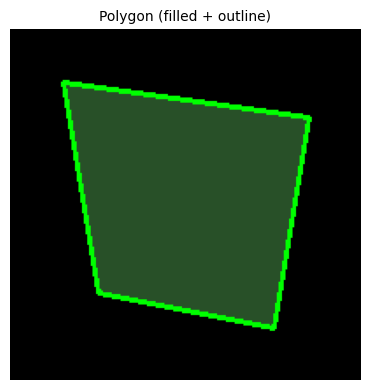

In [7]:
# Polygon creation and drawing
poly = le_geometry.Polygon()
for x, y in [(30, 30), (170, 50), (150, 170), (50, 150)]:
    poly.add_world_vertex(float(x), float(y))

print(f"Polygon: {poly.size} vertices, convex={poly.is_convex}")
print(f"  vertices: {poly.world_vertices()}")

canvas = np.zeros((200, 200, 3), dtype=np.uint8)
poly.fill(canvas, color=[40, 80, 40])
poly.draw(canvas, color=[0, 255, 0], thickness=2)
show_images([canvas], ["Polygon (filled + outline)"])

## 5. Callback Integration — Python Subclassing of C++ Tasks

The `le_eval` module supports **Python subclassing** of C++ base classes via
pybind11 trampolines. This enables event-driven patterns: the C++ benchmark
orchestrator calls back into Python-defined `prepare_impl()` and `run_impl()`
methods.

In [8]:
# Subclass CVPerformanceTask in Python — the C++ framework calls our methods
class ImageStatsTask(le_eval.CVPerformanceTask):
    """A custom task: compute basic image statistics."""

    def __init__(self):
        # TASK_SQR = convert input to grayscale
        super().__init__("ImageStats", le_eval.TASK_SQR, False)
        self.call_log = []

    def prepare_impl(self, src: np.ndarray) -> None:
        """Called by C++ before timing loop — setup phase."""
        self.call_log.append(f"prepare({src.shape})")

    def run_impl(self, name: str, src: np.ndarray) -> None:
        """Called by C++ inside the timing loop — measured phase."""
        self.call_log.append(f"run('{name}', mean={src.mean():.1f})")

# Demonstrate: the C++ would call these, let's call manually to show the pattern
task = ImageStatsTask()
task.prepare_impl(test_img)
task.run_impl("test_image", test_img)

print("Task name:", task.name)
print("Call log:")
for entry in task.call_log:
    print(f"  → {entry}")
print("\nThis pattern enables C++ performance frameworks to benchmark Python code.")

Task name: ImageStats
Call log:
  → prepare((200, 200))
  → run('test_image', mean=67.2)

This pattern enables C++ performance frameworks to benchmark Python code.


## 6. Error Handling and Exception Propagation

C++ exceptions are automatically translated to Python exceptions by pybind11.
Invalid arguments, out-of-range values, and internal errors are properly
propagated.

In [2]:
# 1. Wrong argument types → TypeError from pybind11
try:
    le_geometry.Line("not", "a", "number")
except TypeError as e:
    print(f"✓ TypeError caught: {type(e).__name__}")
    print(f"  {e}\n")

# 2. Wrong argument count
try:
    le_imgproc.RangeI(1, 2, 3, 4)  # expects 2 args, not 4
except TypeError as e:
    print(f"✓ Wrong arg count: {type(e).__name__}")
    print(f"  {e}\n")

# 3. StringTable out-of-range access → IndexError (from bindings bounds check)
try:
    table = le_eval.StringTable(2, 3)
    table[0, 0] = "ok"          # valid access
    _ = table[10, 0]            # row 10 does not exist
except IndexError as e:
    print(f"✓ Out-of-range: {type(e).__name__}")
    print(f"  {e}\n")

# 4. Degenerate line operations are safe (return sentinel values)
empty_line = le_geometry.Line()  # default-constructed = degenerate
print(f"Degenerate line: valid()={empty_line.valid()}, empty()={empty_line.empty()}")
print(f"  distance(0,0) = {empty_line.distance(0.0, 0.0)}")

# Valid line for comparison
good_line = le_geometry.Line(0.0, 1.0, 50.0)
print(f"Valid line:      valid()={good_line.valid()}, empty()={good_line.empty()}")
print(f"  distance(0,0) = {good_line.distance(0.0, 0.0)}")

print("\nAll error cases handled gracefully.")

✓ TypeError caught: TypeError
  __init__(): incompatible constructor arguments. The following argument types are supported:
    1. le_geometry.Line()
    2. le_geometry.Line(normal_x: float, normal_y: float, distance: float)
    3. le_geometry.Line(normal_x: float, normal_y: float, point_x: float, point_y: float)

Invoked with: 'not', 'a', 'number'

✓ Wrong arg count: TypeError
  __init__(): incompatible constructor arguments. The following argument types are supported:
    1. le_imgproc.RangeI(lower: int = 0, upper: int = 0)

Invoked with: 1, 2, 3, 4

✓ Out-of-range: IndexError
  StringTable index out of range

Degenerate line: valid()=False, empty()=True
  distance(0,0) = 0.0
Valid line:      valid()=True, empty()=False
  distance(0,0) = -50.0

All error cases handled gracefully.


## 7. Performance: Native C++ vs Pure Python

Compare the speed of C++ binding calls against equivalent pure-Python
implementations. The C++ code runs optimised SIMD instructions while
the Python code uses NumPy (itself backed by C, but with Python overhead).

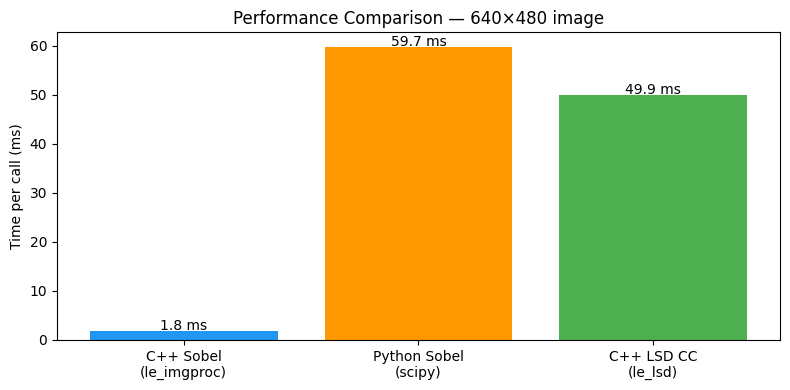

Speedup (C++ Sobel vs Python Sobel): 33.8×


In [11]:
import timeit

# Larger image for meaningful timing
big_img = np.random.randint(0, 256, (480, 640), dtype=np.uint8)

# --- Gradient computation: C++ (le_imgproc) vs Python (numpy) ---

def cpp_sobel():
    grad = le_imgproc.SobelGradient()
    grad.process(big_img)
    _ = grad.magnitude()

def numpy_sobel():
    """Approximate Sobel via numpy convolution (no OpenCV)."""
    kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
    ky = kx.T
    from scipy.signal import convolve2d
    gx = convolve2d(big_img.astype(np.float32), kx, mode="same")
    gy = convolve2d(big_img.astype(np.float32), ky, mode="same")
    _ = np.sqrt(gx**2 + gy**2)

# Benchmark
n_runs = 20
t_cpp = timeit.timeit(cpp_sobel, number=n_runs) / n_runs * 1000
try:
    t_py = timeit.timeit(numpy_sobel, number=n_runs) / n_runs * 1000
except ImportError:
    t_py = None

# --- LSD detection: CC timing ---
def cpp_lsd():
    det = le_lsd.LsdCC()
    det.detect(big_img)
    _ = det.line_segments()

t_lsd = timeit.timeit(cpp_lsd, number=n_runs) / n_runs * 1000

# Visualise
labels = ["C++ Sobel\n(le_imgproc)", "C++ LSD CC\n(le_lsd)"]
times = [t_cpp, t_lsd]
colors = ["#2196F3", "#4CAF50"]

if t_py is not None:
    labels.insert(1, "Python Sobel\n(scipy)")
    times.insert(1, t_py)
    colors.insert(1, "#FF9800")

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(labels, times, color=colors)
ax.set_ylabel("Time per call (ms)")
ax.set_title(f"Performance Comparison — {big_img.shape[1]}×{big_img.shape[0]} image")
for bar, t in zip(bars, times):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.3,
            f"{t:.1f} ms", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

if t_py is not None:
    print(f"Speedup (C++ Sobel vs Python Sobel): {t_py / t_cpp:.1f}×")

## 8. Edge Detection Pipeline — le_edge

Full edge detection pipeline: gradient → NMS → edge segment extraction.
Compare different edge segment detectors (Drawing, Pattern) on the same
input.

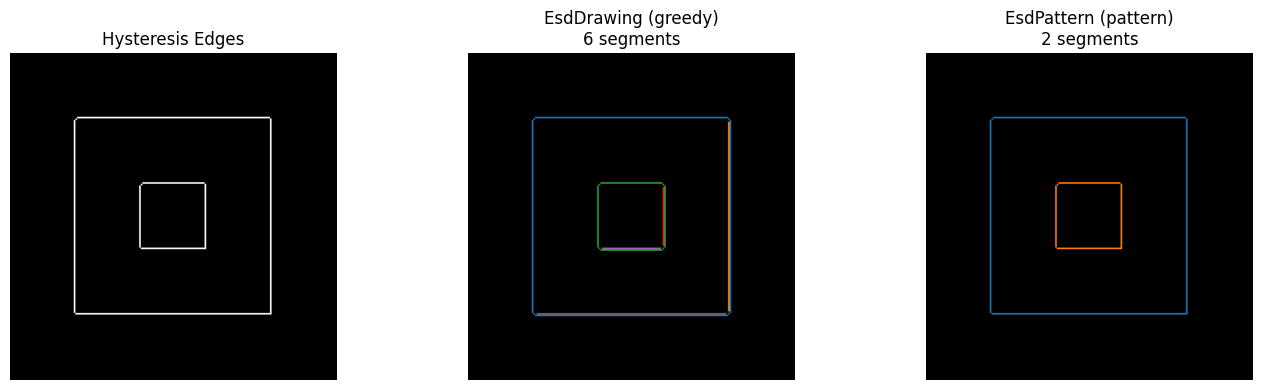

In [12]:
# Edge source: Sobel gradient + NMS + hysteresis
es = le_edge.EdgeSourceSobel()
es.process(test_img)

# Binary edge map from hysteresis thresholding
binary_edges = es.hysteresis_binary()

# Edge segment detection — compare two strategies
detectors = {
    "EsdDrawing (greedy)": le_edge.EsdDrawing(min_pixels=8),
    "EsdPattern (pattern)": le_edge.EsdPattern(min_pixels=8, max_gap=3),
}

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Show binary edges
axes[0].imshow(binary_edges, cmap="gray")
axes[0].set_title("Hysteresis Edges")
axes[0].axis("off")

for idx, (name, esd) in enumerate(detectors.items(), start=1):
    esd.detect(es)
    segments = esd.segments()
    points = esd.points()

    # Render each segment in a different colour
    vis = np.zeros((*test_img.shape, 3), dtype=np.uint8)
    for i, seg in enumerate(segments):
        color = plt.cm.tab10(i % 10)[:3]
        seg_pts = points[seg.begin : seg.end]
        for px_idx in seg_pts:
            r, c = divmod(px_idx, test_img.shape[1])
            if 0 <= r < vis.shape[0] and 0 <= c < vis.shape[1]:
                vis[r, c] = [int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)]

    axes[idx].imshow(vis)
    axes[idx].set_title(f"{name}\n{len(segments)} segments")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

## 9. Real-World Use Case: Complete Line Detection Pipeline

End-to-end example combining all modules:

1. **le_imgproc** — compute gradient magnitude
2. **le_lsd** — detect line segments with all 9 algorithms
3. **le_geometry** — draw and optimise results
4. **le_eval** — measure and compare performance
5. **Export** — results as a formatted table

In [13]:
# Step 1: Create a more complex test image
img = np.zeros((300, 400), dtype=np.uint8)
img[50:250, 80:320] = 180          # large rectangle
img[100:200, 140:260] = 60         # inner rectangle
img[120:180, 170:230] = 220        # bright inner square
# Diagonal line
for i in range(200):
    r, c = 50 + i, 50 + i
    if r < 300 and c < 400:
        img[r, max(0, c-1):min(400, c+2)] = 255

# Step 2: Detect with all 9 LSD algorithms
all_detectors = {
    "CC": le_lsd.LsdCC(),
    "CP": le_lsd.LsdCP(),
    "Burns": le_lsd.LsdBurns(),
    "FBW": le_lsd.LsdFBW(),
    "FGioi": le_lsd.LsdFGioi(),
    "EDLines": le_lsd.LsdEDLZ(),
    "EL": le_lsd.LsdEL(),
    "EP": le_lsd.LsdEP(),
    "HoughP": le_lsd.LsdHoughP(),
}

results = {}
for name, det in all_detectors.items():
    t0 = timeit.default_timer()
    det.detect(img)
    elapsed = (timeit.default_timer() - t0) * 1000
    segs = det.line_segments()
    total_length = sum(s.length for s in segs)
    results[name] = {
        "segments": segs,
        "count": len(segs),
        "total_length": total_length,
        "time_ms": elapsed,
    }

# Step 3: Results table
print(f"{'Detector':<10s} {'Segments':>8s} {'Total Length':>12s} {'Time (ms)':>10s}")
print("-" * 44)
for name, r in results.items():
    print(f"{name:<10s} {r['count']:>8d} {r['total_length']:>12.1f} {r['time_ms']:>10.2f}")

[ INFO:0@120.594] global registry_parallel.impl.hpp:96 ParallelBackendRegistry core(parallel): Enabled backends(0, sorted by priority): N/A
Detector   Segments Total Length  Time (ms)
--------------------------------------------
CC               24       2024.7       4.65
CP               24       2007.0       2.04
Burns            25       2017.0       4.39
FBW              22       2071.7       2.54
FGioi            17       2059.1      15.82
EDLines          17       1103.1       5.89
EL               25       2045.5       4.84
EP               25       2012.5       2.58
HoughP            6       1426.8       7.53


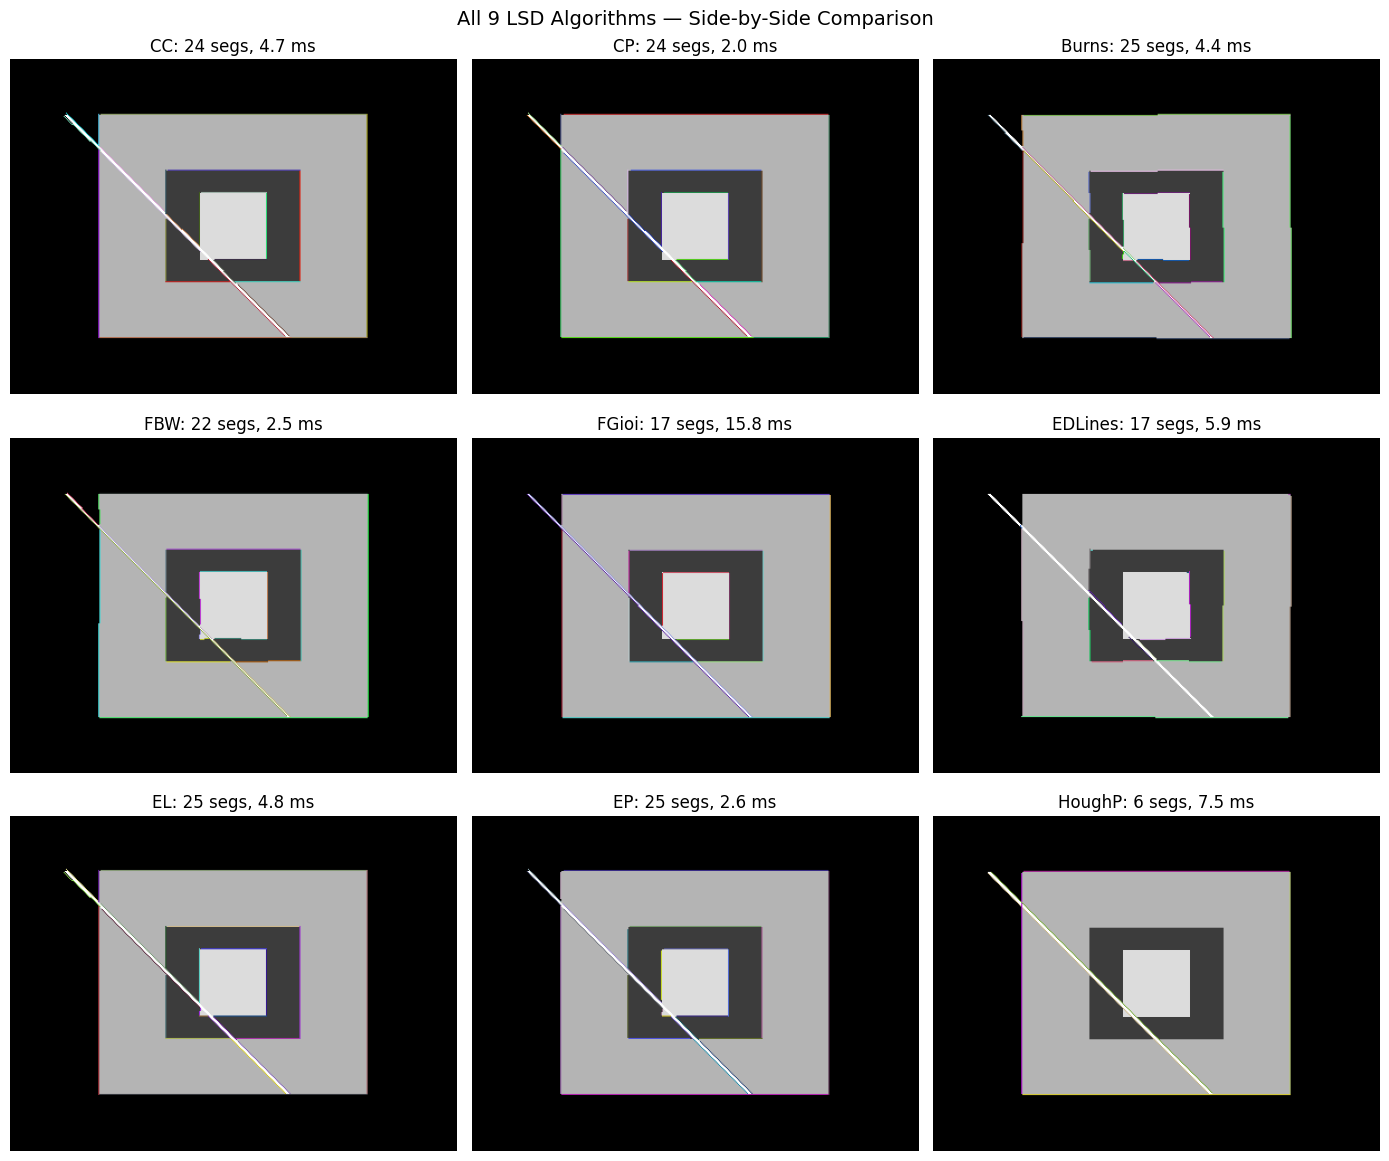

In [14]:
# Step 4: Visualise all detections side by side
fig, axes = plt.subplots(3, 3, figsize=(14, 12))
for ax, (name, r) in zip(axes.flat, results.items()):
    # Create BGR canvas from grayscale (no cv2 needed)
    canvas = np.stack([img, img, img], axis=-1).copy()
    # draw_lines_random returns a new BGR image with random-coloured segments
    canvas = le_geometry.draw_lines_random(canvas, r["segments"])
    # BGR → RGB for matplotlib
    ax.imshow(canvas[:, :, ::-1])
    ax.set_title(f"{name}: {r['count']} segs, {r['time_ms']:.1f} ms")
    ax.axis("off")
plt.suptitle("All 9 LSD Algorithms — Side-by-Side Comparison", fontsize=14)
plt.tight_layout()
plt.show()

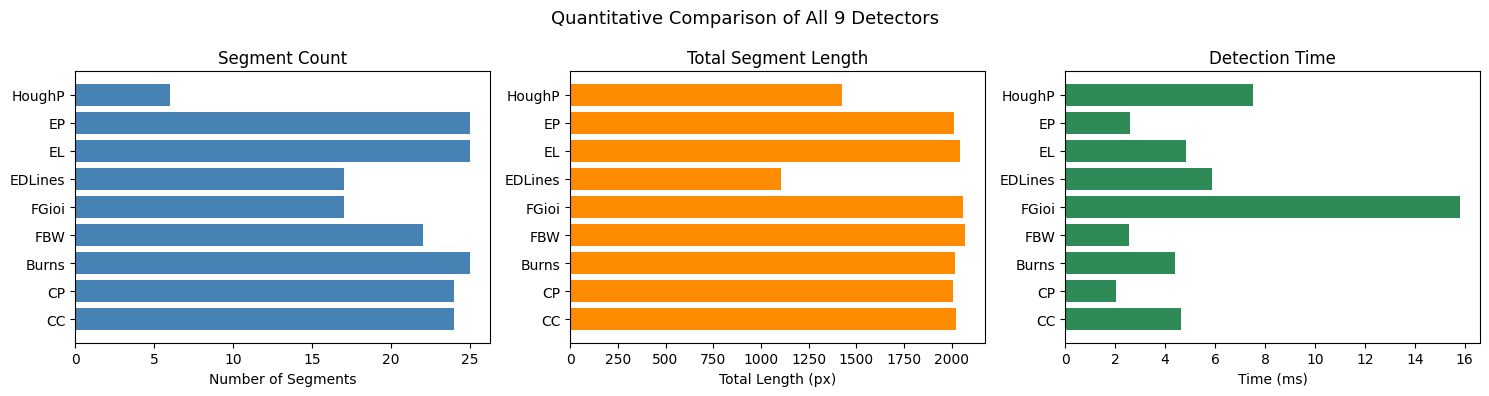


✅ Notebook complete — all 5 modules demonstrated.


In [15]:
# Step 5: Bar chart comparison
names = list(results.keys())
counts = [results[n]["count"] for n in names]
times = [results[n]["time_ms"] for n in names]
lengths = [results[n]["total_length"] for n in names]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.barh(names, counts, color="steelblue")
ax1.set_xlabel("Number of Segments")
ax1.set_title("Segment Count")

ax2.barh(names, lengths, color="darkorange")
ax2.set_xlabel("Total Length (px)")
ax2.set_title("Total Segment Length")

ax3.barh(names, times, color="seagreen")
ax3.set_xlabel("Time (ms)")
ax3.set_title("Detection Time")

plt.suptitle("Quantitative Comparison of All 9 Detectors", fontsize=13)
plt.tight_layout()
plt.show()

print("\n✅ Notebook complete — all 5 modules demonstrated.")